In [470]:
model_name = 'article-bias-2'
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline("text-classification", model=model_name, tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3,output_attentions=True)\
    .to("mps")

In [9]:
def truncate_text(text, tokenizer, max_length=512):
    tokens = tokenizer.tokenize(text)
    truncated_tokens = tokens[:max_length - 2]  # Reserve space for special tokens [CLS] and [SEP]
    truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)
    return truncated_text

In [16]:
import os
import pandas as pd

def load_dataset():
    directory = 'data/jsons'

    dfs = [] # an empty list to store the data frames
    for f in os.listdir(directory):
        file = os.path.join(directory, f)
        data = pd.read_json(file, typ='series').to_frame().T # read data frame from json file
        dfs.append(data) # append the data frame to the list

    df = pd.concat(dfs, ignore_index=True)
    df.drop(['topic', 'source', 'url', 'title', 'date', 'authors', 'content_original', 'source_url', 'bias_text', 'ID'],
            axis=1, inplace=True)
    df['content'] = df['content'].str.replace('[^\w\s]','')
    df['content'] = df['content'].str.lower()
    return df

In [20]:
%%time
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(df, df['bias'].to_numpy(), test_size=0.1, stratify=df['bias'].to_numpy())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1.0/9.0, stratify=y_train)

NUM_CLASSES = len(np.unique(df['bias']))
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
y_val_ohe = keras.utils.to_categorical(y_val, NUM_CLASSES)

def encode(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

train_encodings = encode(X_train['content'].tolist(), tokenizer)
test_encodings = encode(X_test['content'].tolist(), tokenizer)
eval_encodings = encode(X_val['content'].tolist(), tokenizer)

CPU times: user 2min 18s, sys: 2.51 s, total: 2min 21s
Wall time: 20.4 s


In [281]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [4]:
import json
def load_article_json(name):
    with open(f'./data/jsons/{name}.json', 'r') as f:
        data = json.load(f)
        return data

In [15]:
df = load_dataset()

<timed exec>:16: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
article1 = load_article_json('I3B0cfqnYOw0R0Rp')
article1['bias'], article1['bias_text'], article1['title'], article1['source']

(2,
 'right',
 "PA Lawmaker's Bill Would Ban Teachers From Talking Politics in the Classroom",
 'Fox Online News')

In [10]:
text = truncate_text(article1['content'], tokenizer, max_length=500)
text

Token indices sequence length is longer than the specified maximum sequence length for this model (879 > 512). Running this sequence through the model will result in indexing errors


'a pennsylvania state lawmaker is pushing a bill that would ban schoolteachers from talking about modern - day civics, politics and public affairs in the classroom. state rep. will tallman ( r ), who is retiring at the end of the year, sent a memo to his colleagues in the state house last friday seeking support for what he has dubbed the “ teacher code of ethics. ” according to the memo, the bill would prohibit public elementary or secondary schoolteachers, while operating within the scope of their employment, from endorsing, supporting, or opposing any the following : - candidate or nominee for public office or any local, state, or federal official, regardless of whether such official is elected or appointed ; - local, state, or federal legislation or regulation, regardless of whether such legislation or regulation is pending, proposed, or enacted ; - local, state, or federal court case or judicial action, regardless of whether such court case or judicial action is pending, proposed, 

In [193]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
    
def compute_gradients(input_ids, attention_mask, target_label):
    model.zero_grad()

    with torch.no_grad():
        embeddings = model.distilbert.embeddings(input_ids.to("mps"))

    embeddings.requires_grad_(True)

    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask.to("mps"))
    logits = outputs.logits
    target_label_tensor = torch.tensor([target_label], dtype=torch.long).to(logits.device)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(logits, target_label_tensor)
    loss.backward()

    return embeddings.grad
    
def get_topk_tokens(gradients, input_ids, tokenizer, top_k=10):
    gradients = gradients.squeeze().abs().sum(dim=-1).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Get the indices of the top-k influential tokens
    top_k_indices = gradients.argsort()[-top_k:][::-1]
    
    # Get the top-k tokens and their gradients
    top_k_tokens = [tokens[i] for i in top_k_indices]
    top_k_gradients = gradients[top_k_indices]
    return top_k_indices, top_k_tokens, top_k_gradients

    
def visualize_gradients(top_k_gradients, top_k_tokens, top_k=10):
    plt.figure(figsize=(16, 5))
    sns.barplot(y=top_k_tokens, x=top_k_gradients, orient='h')
    plt.xticks(rotation=90)
    plt.xlabel('Gradient value')
    plt.show()
    
def get_topk_ngrams_gradients(gradients, input_ids, attention_masks, tokenizer, n=2, top_k=10):
    gradients = gradients.squeeze().abs().sum(dim=-1).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Aggregate gradients over n-grams
    ngrams_gradients = [gradients[i:i + n].sum() for i in range(len(gradients) - n + 1)]
    ngrams_tokens = [' '.join(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]
    
    # Get the indices of the top-k influential n-grams
    top_k_indices = np.argsort(ngrams_gradients)[-top_k:][::-1]
    
    # Get the top-k n-grams and their gradients
    top_k_ngrams = [ngrams_tokens[i] for i in top_k_indices]
    top_k_ngrams_gradients = [ngrams_gradients[i] for i in top_k_indices]
    return top_k_ngrams, top_k_ngrams_gradients

def visualize_ngrams_gradients(top_k_ngrams, top_k_ngrams_gradients, n=2, top_k=10):
    plt.figure(figsize=(16, 5))
    sns.barplot(y=top_k_ngrams, x=top_k_ngrams_gradients, orient='h')
    plt.xticks(rotation=90)
    plt.show()

In [282]:
import torch

model.eval()
for param in model.parameters():
    param.requires_grad = True


device = "mps"
# Move the model to the device
model = model.to(device)

In [405]:
from collections import Counter
import time


def count_ngram_gradients(inputs_list, target_label, n=2, top_k=50):
    counter = Counter()
    for i, inputs in enumerate(inputs_list['input_ids']):
        attention_mask = inputs_list['attention_mask'][i]
        gradients = compute_gradients(inputs, attention_mask, target_label)
        top_k_ngrams, top_k_ngrams_gradients = get_topk_ngrams_gradients(gradients, inputs, attention_mask, 
                                                                         tokenizer, n=n, top_k=top_k)
        for ngram in top_k_ngrams:
            counter.setdefault(ngram, 0)
            counter[ngram] += 1
    return counter




def count_gradients(inputs_list, target_label, n=2, top_k=50):
    counter = Counter()
    for i, inputs in enumerate(inputs_list['input_ids']):
        attention_mask = inputs_list['attention_mask'][i]
        gradients = compute_gradients(inputs, attention_mask, target_label)
        indices, top_k_tokens, top_k_gradients = get_topk_tokens(gradients, inputs, 
                                                                         tokenizer, top_k=top_k)
        for token in top_k_tokens:
            counter.setdefault(token, 0)
            counter[token] += 1
    return counter


In [194]:
%%time
texts = df['content']
inputs_list = tokenizer(list(texts),
                           max_length=512,
                           padding=True,
                           truncation=True,
                           return_tensors="pt")

CPU times: user 2min 18s, sys: 3.65 s, total: 2min 22s
Wall time: 22.1 s


In [ ]:
%%time
left_leaning_counter = count_ngram_gradients(inputs_list, target_label=0)
right_leaning_counter = count_ngram_gradients(inputs_list, target_label=2)

In [223]:
lcounter = Counter(dict(left_leaning_counter.most_common(100)))
rcounter = Counter(dict(right_leaning_counter.most_common(100)))

In [ ]:
left_leaning_counter2 = Counter({k: v for k,v in left_leaning_counter.items() if k not in rcounter})

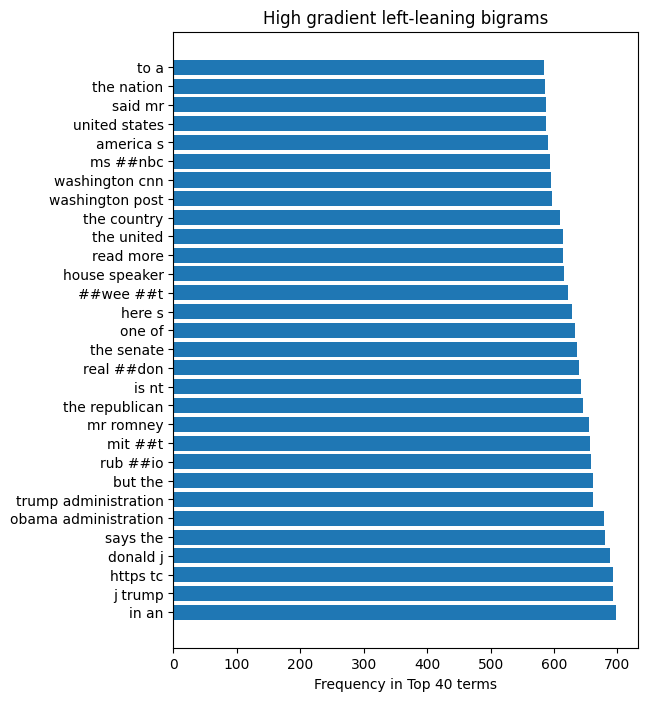

In [372]:
labels, counts = zip(*dict(left_leaning_counter2.most_common(30)).items())
fig, ax = plt.subplots(figsize=(6, 8))
ax.barh(labels, counts)
ax.set_xlabel('Frequency in Top 40 terms')
ax.set_title('High gradient left-leaning bigrams')
plt.show()

In [363]:
right_leaning_counter2 = Counter({k: v for k,v in right_leaning_counter.items() if k not in lcounter})

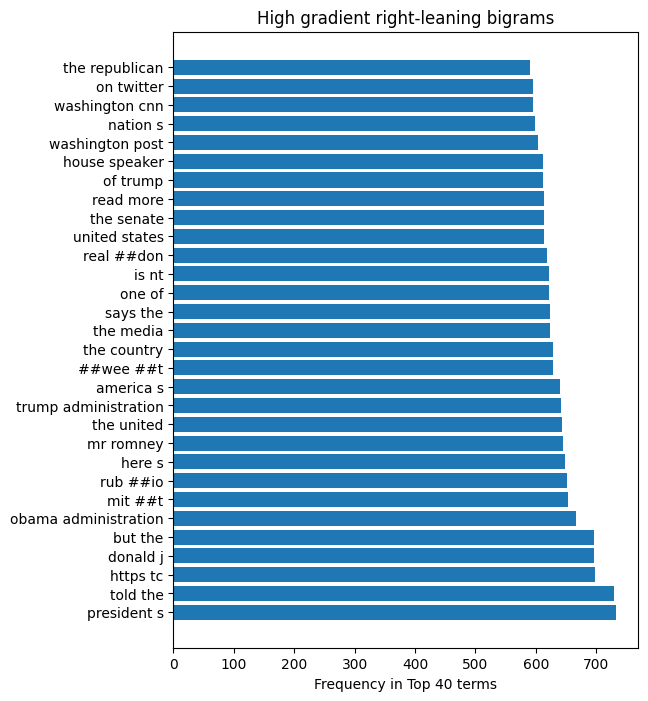

In [373]:
labels, counts = zip(*dict(right_leaning_counter2.most_common(30)).items())
fig, ax = plt.subplots(figsize=(6, 8))
ax.barh(labels, counts)
ax.set_xlabel('Frequency in Top 40 terms')
ax.set_title('High gradient right-leaning bigrams')
plt.show()

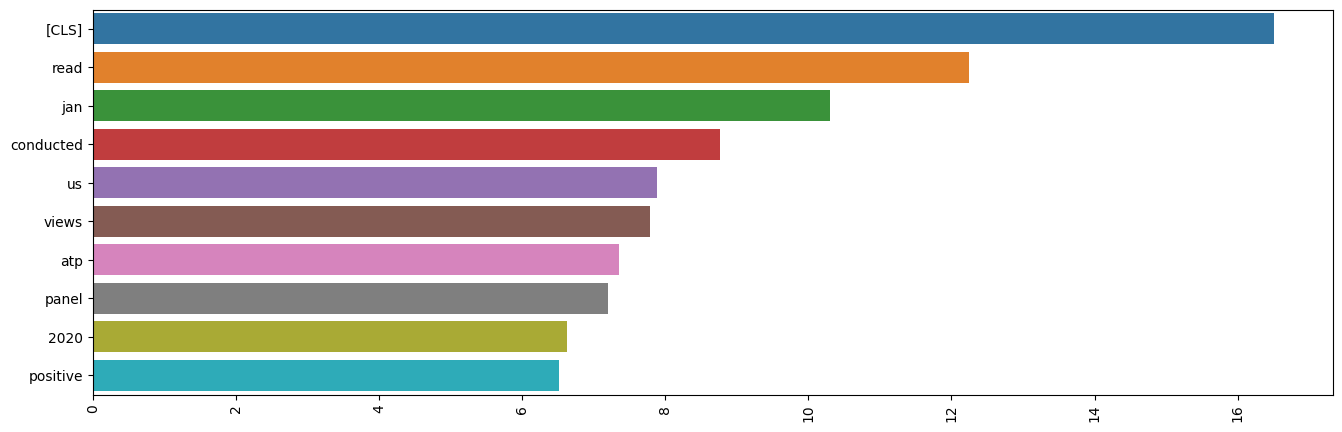

In [411]:
example = df['content'][33]
example_tokenized = tokenizer(example,
                           max_length=512,
                           padding=True,
                           truncation=True,
                           return_tensors="pt")
gradients = compute_gradients(example_tokenized['input_ids'][0], example_tokenized['attention_mask'], target_label=2)
top_k_indices, top_k_tokens, top_k_gradients = get_topk_tokens(gradients, example_tokenized['input_ids'][0], tokenizer, top_k=10)
visualize_gradients(top_k_gradients, top_k_tokens, top_k=10)

In [384]:
left_texts = df[df['bias'] == 0].sample(3300)['content']

def encode(texts):
    return tokenizer(list(texts),max_length=512, padding=True,
              truncation=True, return_tensors="pt")

left_texts_counts = count_ngram_gradients(encode(left_texts), target_label=0)

right_texts = df[df['bias'] == 2].sample(3300)['content']
right_texts_counts = count_ngram_gradients(encode(right_texts), target_label=2)

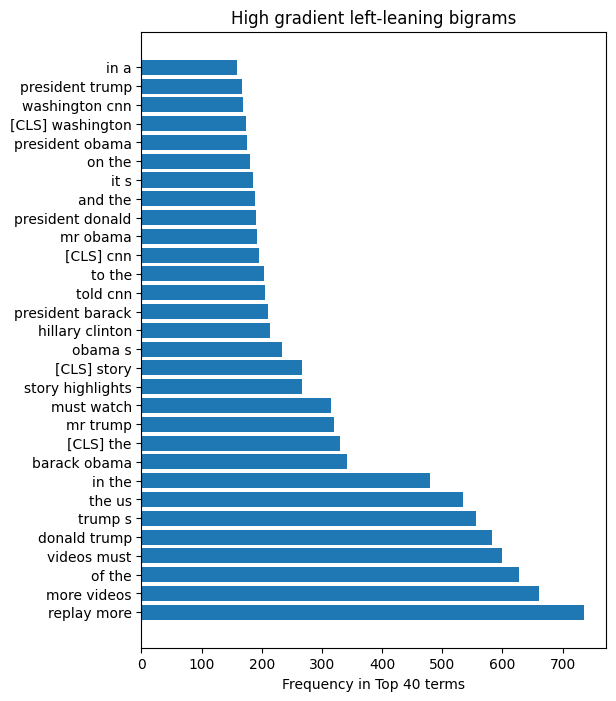

In [388]:
labels, counts = zip(*dict(left_texts_counts.most_common(30)).items())
fig, ax = plt.subplots(figsize=(6, 8))
ax.barh(labels, counts)
ax.set_xlabel('Frequency in Top 40 terms')
ax.set_title('High gradient left-leaning bigrams')
plt.show()

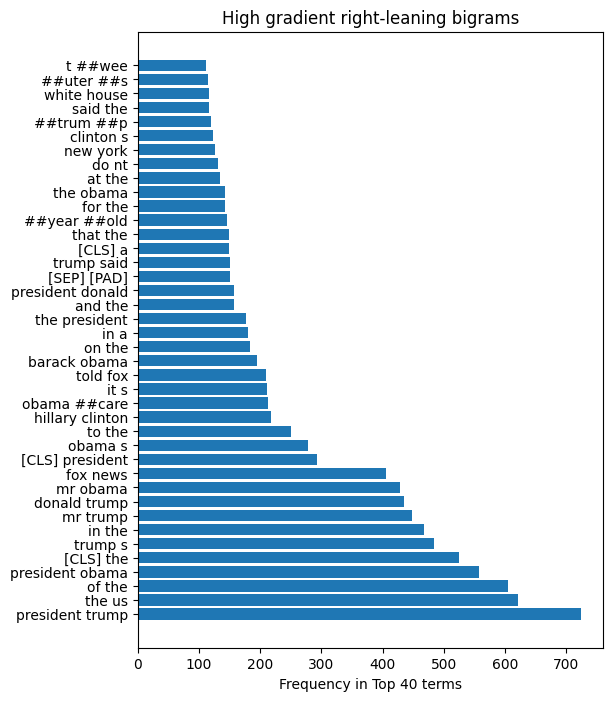

In [391]:
labels, counts = zip(*dict(right_texts_counts.most_common(40)).items())
fig, ax = plt.subplots(figsize=(6, 8))
ax.barh(labels, counts)
ax.set_xlabel('Frequency in Top 40 terms')
ax.set_title('High gradient right-leaning bigrams')
plt.show()

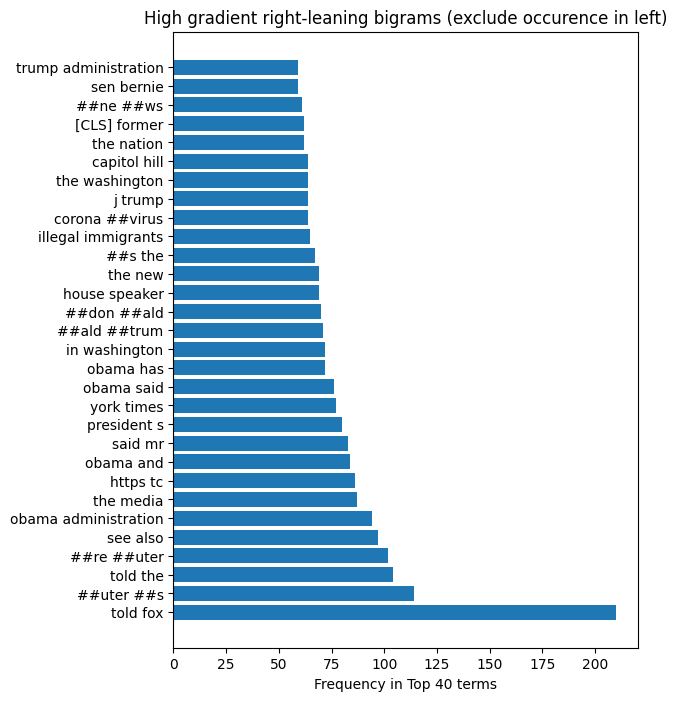

In [423]:
temp = dict(left_texts_counts.most_common(100))
d = Counter({k: v for k, v in dict(right_texts_counts.most_common(1000)).items() if k not in temp})
labels, counts = zip(*dict(d.most_common(30)).items())
fig, ax = plt.subplots(figsize=(6, 8))
ax.barh(labels, counts)
ax.set_xlabel('Frequency in Top 40 terms')
ax.set_title('High gradient right-leaning bigrams (exclude occurence in left)')
plt.show()

In [392]:
left_texts2 = df[df['bias'] == 0].sample(330)['content']

def encode(texts):
    return tokenizer(list(texts),max_length=512, padding=True,
              truncation=True, return_tensors="pt")

left_texts_counts2 = count_ngram_gradients(encode(left_texts2), target_label=0, n=4)

right_texts2 = df[df['bias'] == 2].sample(330)['content']
right_texts_counts2 = count_ngram_gradients(encode(right_texts2), target_label=2, n=4)

In [475]:
example = df['content'][110]
label = df['bias'][110]
print('label:', label)
example_tokenized = tokenizer(example,
                           max_length=512,
                           padding=True,
                           truncation=True,
                           return_tensors="pt")
print(tokenizer.batch_decode(example_tokenized['input_ids'])[0])
print(pipe(truncate_text(example, tokenizer)))

label: 2
[CLS] republicans on monday blasted secretary of state john kerry for suggesting in a letter to his iranian counterpart that the administration could help the country get around new visa restrictions passed by congress instead of bending over backwards to try to placate the iranian regime the white house needs to be holding it accountable for its recent missile tests its continued support for terrorism and its wrongful imprisonment of americans house foreign affairs committee chairman ed royce rcalif said in a statement to foxnewscom at issue are tightened security requirements for america s visa waiver program which allows citizens of 38 countries to travel to the us without visas under changes in the newly signed spending bill people from those countries who have traveled to iran iraq syria and sudan in the past five years must now obtain visas to enter the us top tehran officials however complained the changes violate the terms of the nuclear deal which says the us and othe

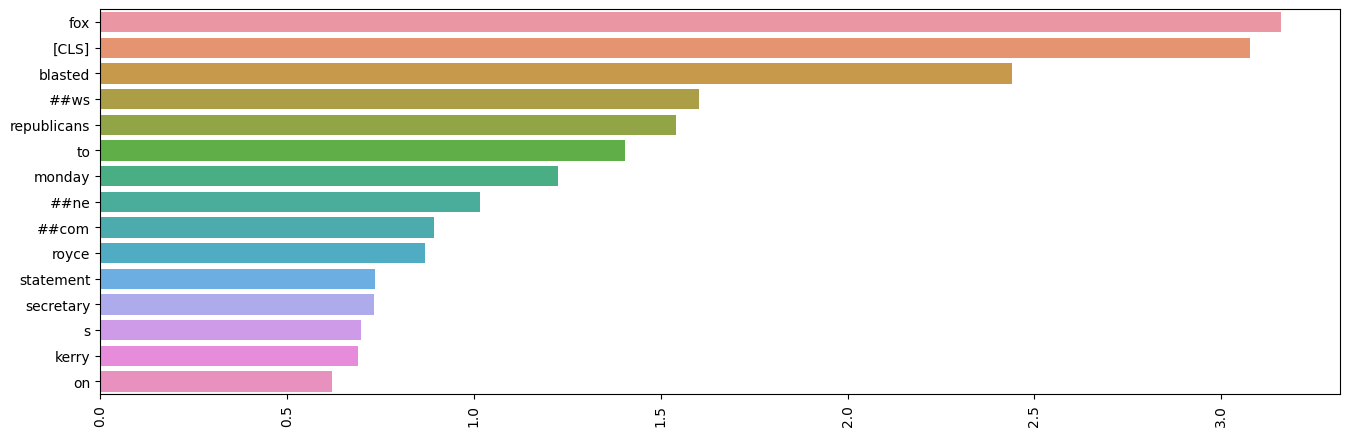

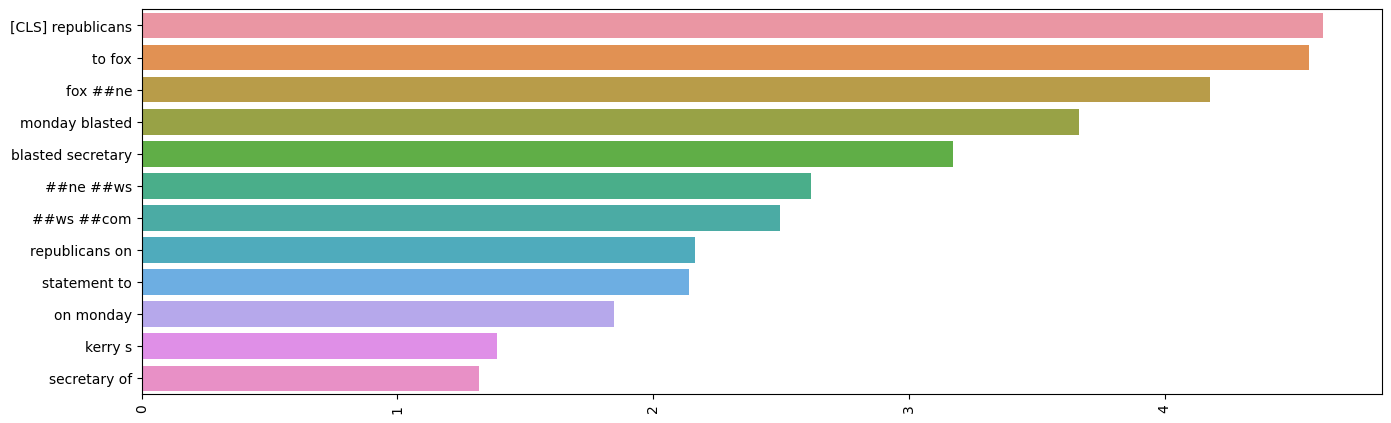

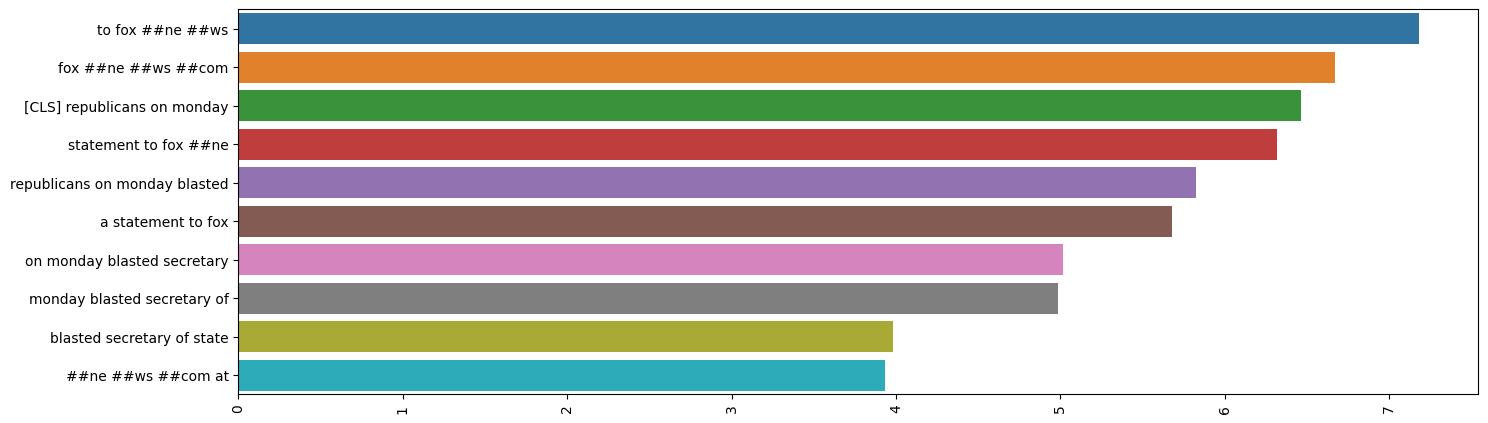

In [476]:
gradients = compute_gradients(example_tokenized['input_ids'], example_tokenized['attention_mask'], 
                              target_label=label)
top_k_indices, top_k_tokens, top_k_gradients = get_topk_tokens(gradients, example_tokenized['input_ids'][0], 
                                                               tokenizer, top_k=15)
visualize_gradients(top_k_gradients, top_k_tokens, top_k=15)

top_k_ngrams, top_k_ngrams_gradients = get_topk_ngrams_gradients(gradients, example_tokenized['input_ids'][0], example_tokenized['attention_mask'], 
                                                                 tokenizer, n=2, top_k=12)
visualize_ngrams_gradients(top_k_ngrams, top_k_ngrams_gradients, n=2, top_k=12)

top_k_ngrams, top_k_ngrams_gradients = get_topk_ngrams_gradients(gradients, example_tokenized['input_ids'][0], example_tokenized['attention_mask'], 
                                                                 tokenizer, n=4, top_k=10)
visualize_ngrams_gradients(top_k_ngrams, top_k_ngrams_gradients, n=4, top_k=10)